## Experiment on person scheme

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as et
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

sns.set()

### Connect to the database

In [2]:
%run connection.ipynb

Connecting with connection string : postgresql://postgres:letmein@db:5432/Adventureworks
 * postgresql://postgres:***@db:5432/Adventureworks
1 rows affected.
 * postgresql://postgres:***@db:5432/Adventureworks
1 rows affected.
 * postgresql://postgres:***@db:5432/Adventureworks
68 rows affected.


### Customer segmentation

In [3]:
%%sql demographics_df <<

SELECT
    pn.businessentityid,
    (pn.firstname || ' ' || pn.lastname) AS name,
    pn.demographics
FROM person.person pn
WHERE pn.persontype = 'IN'

 * postgresql://postgres:***@db:5432/Adventureworks
18484 rows affected.
Returning data to local variable demographics_df


In [4]:
def expand_demographics(item):
    ns = '{http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/IndividualSurvey}'
    xmlstring = item['demographics']
    tree = et.ElementTree(et.fromstring(xmlstring))
    root = tree.getroot()

    for element in root:
        item[element.tag.replace(ns, '')] = element.text

    return item

In [5]:
demographics_df = demographics_df.apply(expand_demographics, axis=1)

In [6]:
demographics_df.head()

,businessentityid,name,demographics,TotalPurchaseYTD,DateFirstPurchase,BirthDate,MaritalStatus,YearlyIncome,Gender,TotalChildren,NumberChildrenAtHome,Education,Occupation,HomeOwnerFlag,NumberCarsOwned,CommuteDistance
0,1699,David Robinett,"<IndividualSurvey xmlns=""http://schemas.micros...",-16.01,2003-09-01Z,1961-02-23Z,M,25001-50000,M,4,0,Graduate Degree,Clerical,1,0,0-1 Miles
1,1700,Rebecca Robinson,"<IndividualSurvey xmlns=""http://schemas.micros...",-4,2004-06-05Z,1965-06-11Z,M,50001-75000,F,3,3,Bachelors,Professional,1,1,5-10 Miles
2,1701,Dorothy Robinson,"<IndividualSurvey xmlns=""http://schemas.micros...",4730.04,2002-04-07Z,1954-09-23Z,S,75001-100000,M,2,0,Partial College,Skilled Manual,0,2,1-2 Miles
3,1702,Carol Ann Rockne,"<IndividualSurvey xmlns=""http://schemas.micros...",2435.4018,2001-10-27Z,1943-07-15Z,M,25001-50000,M,1,0,Bachelors,Clerical,1,0,0-1 Miles
4,1703,Scott Rodgers,"<IndividualSurvey xmlns=""http://schemas.micros...",1647,2002-04-18Z,1968-05-15Z,M,50001-75000,M,2,2,Bachelors,Professional,1,1,2-5 Miles


In [7]:
df = demographics_df[[
    # 'MaritalStatus',
    'YearlyIncome',
    # 'Gender',
    # 'TotalChildren',
    # 'NumberChildrenAtHome',
    'Education',
    'Occupation',
    'HomeOwnerFlag',
    # 'NumberCarsOwned',
    # 'CommuteDistance'
]]


In [8]:
df.head()

,YearlyIncome,Education,Occupation,HomeOwnerFlag
0,25001-50000,Graduate Degree,Clerical,1
1,50001-75000,Bachelors,Professional,1
2,75001-100000,Partial College,Skilled Manual,0
3,25001-50000,Bachelors,Clerical,1
4,50001-75000,Bachelors,Professional,1


### Encode categorical features as a one-hot numeric array (OneHotEncoder).

In [9]:
X = df.select_dtypes(include=[object])

In [10]:
X.head()

,YearlyIncome,Education,Occupation,HomeOwnerFlag
0,25001-50000,Graduate Degree,Clerical,1
1,50001-75000,Bachelors,Professional,1
2,75001-100000,Partial College,Skilled Manual,0
3,25001-50000,Bachelors,Clerical,1
4,50001-75000,Bachelors,Professional,1


In [11]:
encoder = OneHotEncoder(handle_unknown='ignore')

In [12]:
enc_df = pd.DataFrame(encoder.fit_transform(X).toarray(), columns=encoder.get_feature_names_out())

In [13]:
enc_df.astype(int).head()

,YearlyIncome_0-25000,YearlyIncome_25001-50000,YearlyIncome_50001-75000,YearlyIncome_75001-100000,YearlyIncome_greater than 100000,Education_Bachelors,Education_Graduate Degree,Education_High School,Education_Partial College,Education_Partial High School,Occupation_Clerical,Occupation_Management,Occupation_Manual,Occupation_Professional,Occupation_Skilled Manual,HomeOwnerFlag_0,HomeOwnerFlag_1
0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0
3,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1


In [14]:
enc_df.shape

(18484, 17)

### Reduce the dimensions using Principal Component Analysis (PCA)

In [15]:
pca = PCA()

In [16]:
scores_pca = pca.fit_transform(enc_df.astype(int))

In [35]:
scores_pca

array([[-0.11567623, -0.97685259, -0.20640564, ..., -0.11419961,
        -0.11821345,  0.16027509],
       [-0.96630334,  0.69711116, -0.23141539, ...,  0.00666641,
        -0.03850391,  0.00158845],
       [ 0.84199923,  0.23418072, -0.17060417, ..., -0.16186898,
         0.11449726,  0.23663259],
       ...,
       [-0.8858326 ,  0.32326932, -0.32678242, ..., -0.3968457 ,
         0.1610079 , -0.27294417],
       [ 0.1078931 , -1.07830561, -0.01844522, ..., -0.20533729,
         0.14803561,  0.01265077],
       [ 0.39030464,  1.12586951, -0.58519998, ..., -0.0539495 ,
        -0.09509661,  0.13994248]])

In [85]:
scores_pca.shape

(18484, 12)

### Deciding how many features we’d like to keep based on the cumulative variance plot

In [17]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [1.71016475e-01 1.50395631e-01 1.16366431e-01 1.11059316e-01
 9.18987659e-02 7.84347326e-02 7.38027641e-02 6.69705871e-02
 4.86800371e-02 3.26895853e-02 3.16822501e-02 2.00896143e-02
 6.91380970e-03 8.65418066e-31 2.91530091e-31 9.52978135e-32
 1.13086330e-32]


In [18]:
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))

Cumulative variance explained by 2 principal components: 100.00%


Text(0, 0.5, 'Cumulative Explained Variance')

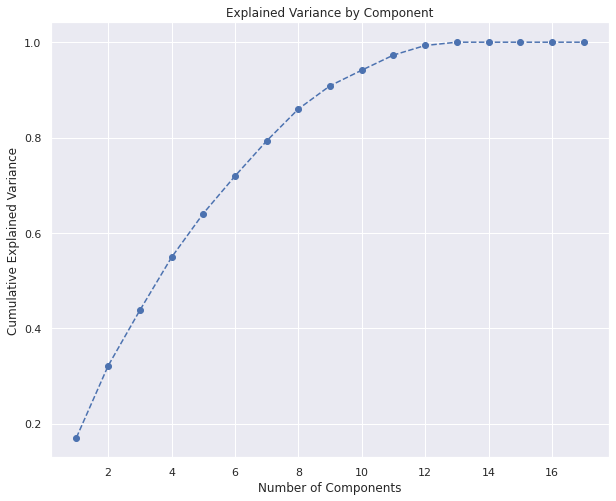

In [19]:
plt.figure(figsize=(10,8))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')

plt.title('Explained Variance by Component')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

### Performing PCA with the chosen number of components.

In [20]:
pca = PCA(n_components=12)

In [21]:
scores_pca = pca.fit_transform(enc_df.astype(int))

In [22]:
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))

Cumulative variance explained by 2 principal components: 99.31%


### Finding optimal `n` value for KMeans 

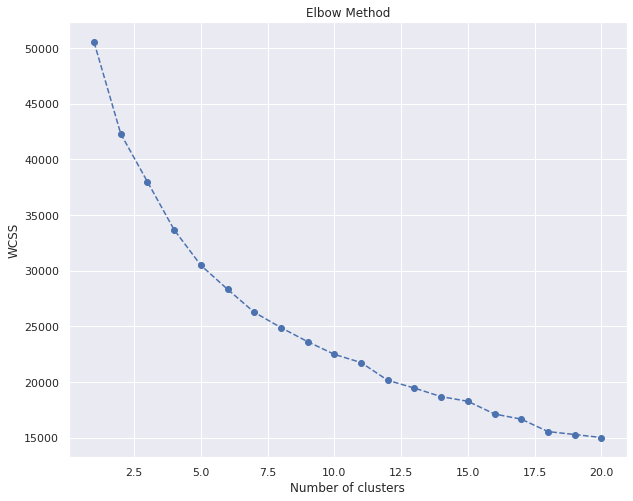

In [23]:
wcss = []

plt.figure(figsize=(10,8))

for i in range(1, 21):
    kmeans=KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=42)
    kmeans.fit(scores_pca)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Applying KMeans

In [24]:
kmeans = KMeans(n_clusters=4)

In [25]:
kmeans4 = kmeans.fit(scores_pca)

In [26]:
kmeans4.labels_

array([1, 2, 0, ..., 2, 1, 0], dtype=int32)

In [27]:
 demographics_df['score'] = pd.Series(kmeans4.labels_)

In [28]:
demographics_df.head()

,businessentityid,name,demographics,TotalPurchaseYTD,DateFirstPurchase,BirthDate,MaritalStatus,YearlyIncome,Gender,TotalChildren,NumberChildrenAtHome,Education,Occupation,HomeOwnerFlag,NumberCarsOwned,CommuteDistance,score
0,1699,David Robinett,"<IndividualSurvey xmlns=""http://schemas.micros...",-16.01,2003-09-01Z,1961-02-23Z,M,25001-50000,M,4,0,Graduate Degree,Clerical,1,0,0-1 Miles,1
1,1700,Rebecca Robinson,"<IndividualSurvey xmlns=""http://schemas.micros...",-4,2004-06-05Z,1965-06-11Z,M,50001-75000,F,3,3,Bachelors,Professional,1,1,5-10 Miles,2
2,1701,Dorothy Robinson,"<IndividualSurvey xmlns=""http://schemas.micros...",4730.04,2002-04-07Z,1954-09-23Z,S,75001-100000,M,2,0,Partial College,Skilled Manual,0,2,1-2 Miles,0
3,1702,Carol Ann Rockne,"<IndividualSurvey xmlns=""http://schemas.micros...",2435.4018,2001-10-27Z,1943-07-15Z,M,25001-50000,M,1,0,Bachelors,Clerical,1,0,0-1 Miles,1
4,1703,Scott Rodgers,"<IndividualSurvey xmlns=""http://schemas.micros...",1647,2002-04-18Z,1968-05-15Z,M,50001-75000,M,2,2,Bachelors,Professional,1,1,2-5 Miles,2


Text(0, 0.5, 'y')

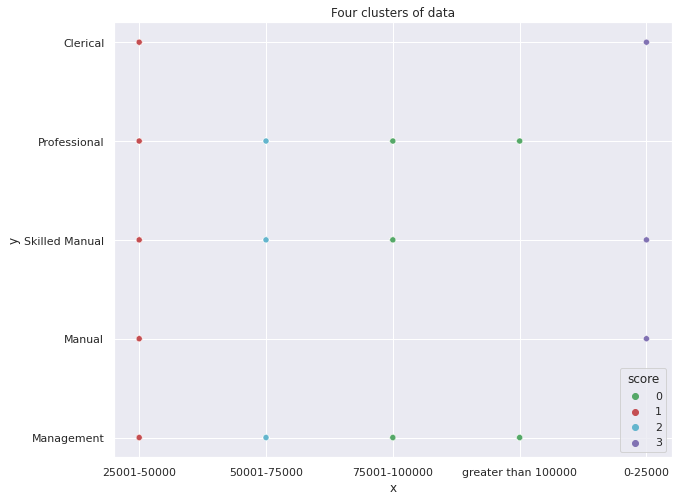

In [84]:

plt.figure(figsize=(10,8))

sns.scatterplot(
    x=demographics_df['YearlyIncome'],
    y=demographics_df['Occupation'],
    hue=demographics_df['score'],
    marker="o",
    palette=['g', 'r', 'c', 'm']
)

# for (cx, cy) in kmeans4.cluster_centers_:
#     plt.plot(cx, cy, color='black', marker='x', mew=2)

plt.title('Four clusters of data')
plt.xlabel('x')
plt.ylabel('y')